# **Predicción resultados partigas PUBG - Entrega final**

![image info](https://assets.goal.com/v3/assets/bltcc7a7ffd2fbf71f5/bltef3283334c7a2677/60de056d2446e93b5b6c87d6/8d9c326c1ca413195b04107a072c6e81a27962e0.jpg)

***Introducción.***

El Players Unknown Battlegrounds (PUBG de aquí en adelante) es un videojuego disponible para varias consolas (PC, PS4, PS5, Xbox y móviles) de los denominados battle royale, que puede jugarse en primera o tercera persona. Hasta un máximo de 100 jugadores saltan en paracaídas de un avión en algún momento de su recorrido, aterrizando en un mapa completamente desequipados. A partir de allí buscarán equiparse lo mejor posible con armas, municiones, miras, consumibles; teniendo como objetivo final matar al resto de los jugadores y ser los últimos en pie. La partida puede jugarse en modo solo o cooperativo, y la zona de mapa habitable se va cerrando con el paso del tiempo forzando así encuentros entre jugadores.

***Motivación y audiencia.***

Un sitio de apuestas online desea incluir entre sus eventos de apuesta, las partidas del torneo 'PUBG Global Championship'. Para ello, requieren poder predecir el resultado de las mismas, de manera que luego ellos puedan calcular las cuotas deportivas y los favoritos a ganar cada fase (y ajustar las mismas conforme esta se vaya desarrollando); tomando apuestas de acuerdo a esta información.

***Problema a resolver.***

La tarea consistirá en predecir el resultado de una partida a disputarse (ranking de un jugador); identificando a lo largo del proceso las variables que mayor influencia tienen en ella.

***Contexto analítico.***

En entregas anteriores, se trabajó con un conjunto de datos con resultados de partidas recopilado para jugadores de diverso nivel, y sus correspondientes estadísticas. Este presentaba métricas como asistencias, distancia recorrida a pie, en vehículos, daño infligido, etc. y por supuesto ranking final en la partida. Los datos fueron cargados desde un archivo '.csv', y a partir de estos se construyó un modelo inicial de predicción del ranking.

Para esta entrega se realizará la comunicación con el servidor de PUBG a través de la API, y se descargaran las métricas de las últimas partidas de un listado de jugadores de nivel competitivo (las correspondientes a los últimos 14 días, que es lo que guarda el servidor). Se procesará luego la información descargada, limpiándola de ser necesario, se presentarán insights obtenidos a partir de ella y por último se aplicarán modelos de Machine Learning midiendo su performance.

### ***Instalación e importacion de librerías***

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     | 22.6 MB 28.5 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 21.6 MB/s eta 0:00:00
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=356305 sha256=ebbbc17648369b8854ab0d9ad25065b724138235f22d506a711d93d560634948
  Stored in directory: /tmp/pip-ephem-wheel-cache-zhtje14b/wheels/07/29/61/f533cc7cbd0a97efb2d1b94d3254a3e859a949367ba842577b
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27079 sha256=b1637283561b9d959b94b5fe57cb19b124e586ad32999ccff4213f52380991fa
  Stored in directory: /roo

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.9 MB/s eta 0:00:00


In [ ]:
import requests
import json
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import ydata_profiling
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

### ***Data scraping***

In [ ]:
# Shard specification: url = "https://api.pubg.com/shards/[SHARD HERE]/"
# El shard hace referencia a la plataforma de la que se buscan datos (Xbox, PS4, PS5, PC, Mobile)

url = "https://api.pubg.com/shards/steam/"

# "Authorization": "Bearer [API KEY HERE]",

key = "" # Insertar API Key

headers = {
  "Authorization": "Bearer "+ key,
  "Accept": "application/vnd.api+json"
}

In [ ]:
# Lista de nombres de jugadores
player_name = ['xmpl', 'ADOUZ1E', 'f1lfirst', 'Besto', 'Qwizzy', 'GOOSYARA666', 'fate', 'hallomybad', 'HalloSenpai', 'xwudd', 'Kickstart', 'TGLTN',
               'Snakers', '2heart', 'Akita', 'Ming', 'Perfect1ks', 'D1gg3r1', 'Shrimzy', 'Nourinz', 'Hikari', 'jeemzz', 'Fexx', 'Inonix', 'Relo',
               'Marcelek', 'penta', 'Seongjang', 'DG98', 'Aitzy', 'DuCkHjeUz', 'Nannnnn', 'nicoos', 'LashK', 'KnorkiS', 'hwinn', 'sparkingg',
               'Ykikamucow', 'PurdyKurty', 'M1ME', 'Noardra', 'Mellman', 'Lukarux', 'K4pii', 'Naylup', 'Krunio', 'clib', 'Molodoct']

# Se inicializa el dataframe donde se volcará la información de la partida, y se crea la columna extra que guardará las fechas
data = pd.DataFrame()
data.insert(0, column='dates', value=None)

def participant_performance(player_name, match_stat):

  """ Función que devuelve stats finales de la partida para el jugador e id de partida especificados """
  sub = pd.Series(dtype='object')
  match_included = match_stat['included']
  for i in match_included:
    if (i['type'] == 'participant' and i['attributes']['stats']['name'] == player_name):
      sub = i['attributes']['stats']
  return sub

# Se hace una iteración por todos los nombres de jugadores especificados
for plyr in player_name:
  # Se filtra la url por nombre de jugador
  player_stats_url = url + "players?filter[playerNames]=" + plyr

  # Se realiza el requests; si es exitoso se descarga la información del jugador, caso contrario pasa al siguiente de la lista
  r = requests.get(player_stats_url, headers = headers)
  if r.status_code == 200:
	  print(plyr, "successfully retrieved!!!")
  else:
    print(plyr, "failed to Connect!!!")
    continue

  # Se pone un tiempo de espera de 6s para que el servidor no me corte el acceso
  time.sleep(6)
  player_stat = json.loads(r.text)
  match_id_list = player_stat['data'][0]['relationships']['matches']['data']

  # Por cada jugador, se realiza una iteración por cada una de sus partidas
  for match in match_id_list:
    match_id = match['id']
    match_url = url + "matches/{}".format(match_id)
    match_r = requests.get(match_url, headers = headers)
    if match_r.status_code != 200:
      print("\tFailed to connect to match data!!!")
      continue
    match_stat = json.loads(match_r.text)

    # Se van concatenando los resultados de cada partida para cada jugador, y las fechas en una lista aparte
    data = pd.concat([data, pd.Series(participant_performance(plyr, match_stat)).to_frame().T])
    data.iloc[-1, 0] = match_stat['data']['attributes']['createdAt']

xmpl successfully retrieved!!!
ADOUZ1E successfully retrieved!!!
f1lfirst successfully retrieved!!!
Besto successfully retrieved!!!
Qwizzy successfully retrieved!!!
GOOSYARA666 successfully retrieved!!!
fate successfully retrieved!!!
hallomybad successfully retrieved!!!
HalloSenpai successfully retrieved!!!
xwudd successfully retrieved!!!
Kickstart successfully retrieved!!!
TGLTN successfully retrieved!!!
Snakers successfully retrieved!!!
2heart successfully retrieved!!!
Akita successfully retrieved!!!
Ming successfully retrieved!!!
Perfect1ks successfully retrieved!!!
D1gg3r1 successfully retrieved!!!
Shrimzy successfully retrieved!!!
Nourinz successfully retrieved!!!
Hikari successfully retrieved!!!
jeemzz successfully retrieved!!!
Fexx successfully retrieved!!!
Inonix successfully retrieved!!!
Relo successfully retrieved!!!
Marcelek successfully retrieved!!!
penta successfully retrieved!!!
Seongjang successfully retrieved!!!
DG98 successfully retrieved!!!
Aitzy successfully retrieve

Se arma un ciclo for, en el que se va recorriendo la lista ```player_name```; por cada jugador se chequea en el servidor si este posee partidas recientes. En caso afirmativo se descargan las estadísticas finales y se van concatenando las mismas en un df.

### ***Exploración de los datos***

Se explorará como quedó conformado el df con las partidas de todos los jugadores.

In [ ]:
data.reset_index(inplace=True, drop=True)

data.head()

,dates,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,2023-08-07T21:09:19Z,0,0,0,4752.335,byplayer,16,0,1,3,...,0,0,0,0,0,1200,0,0,1,1
1,2023-08-07T20:08:11Z,9,3,9,2179.9023,byplayer,2,1,1,3,...,0,4051.367,0,0,0,1420,1,1602.0251,7,3
2,2023-08-07T19:55:17Z,1,4,1,278.54318,byplayer,0,3,10,1,...,3,962.17194,0,0,0,539,0,866.34393,4,13
3,2023-08-07T19:36:06Z,3,1,2,313.16425,byplayer,1,2,5,2,...,0,4964.3877,0,0,0,736,0,748.8619,4,8
4,2023-08-07T19:23:59Z,1,0,2,156.78546,byplayer,0,1,18,1,...,1,1780.3522,0,0,0,410,0,467.64468,6,13


In [ ]:
data.shape

(3224, 24)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3224 entries, 0 to 3223
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   dates            3224 non-null   object
 1   DBNOs            3224 non-null   object
 2   assists          3224 non-null   object
 3   boosts           3224 non-null   object
 4   damageDealt      3224 non-null   object
 5   deathType        3224 non-null   object
 6   headshotKills    3224 non-null   object
 7   heals            3224 non-null   object
 8   killPlace        3224 non-null   object
 9   killStreaks      3224 non-null   object
 10  kills            3224 non-null   object
 11  longestKill      3224 non-null   object
 12  name             3224 non-null   object
 13  playerId         3224 non-null   object
 14  revives          3224 non-null   object
 15  rideDistance     3224 non-null   object
 16  roadKills        3224 non-null   object
 17  swimDistance     3224 non-null   

**Descripción de las columnas**

* ```'dates'```: Fecha y hora de la partida.
* ```'DBNOs'```: Número de enemigos knockeados. Nota: todo jugador que reciba un daño considerable pero no fatal se considera knockeado; en este estado solo podrá arrastrarse y su única opción es esperar a ser revivido por un compañero.
* ```'assists'```: Número de jugadores enemigos que fueron dañados por el jugador y posteriormente muertos por un compañero.
* ```'boosts'```: Cantidad de items de boost utilizados.
* ```'damageDealt'```: Daño infligido a enemigos.
* ```'deathType'```: Tipo de muerte del jugador.
* ```'headshotKills'```: Cantidad de enemigos muertos por disparos a la cabeza.
* ```'heals'```: Cantidad de items de curación utilizados.
* ```'killPlace'```: Ranking en cuanto a cantidad de enemigos matados.
* ```'killStreaks'```: Cantidad de enemigos matados en un corto periodo de tiempo (racha de muertes).
* ```'kills'```: Cantidad de enemigos matados.
* ```'longestKill'```: Mayor distancia entre un enemigo matado y el jugador al momento de su muerte. Nota: puede ser engañoso ya que un enemigo pasará a estar en principio knockeado, y luego morirá desangrado si no lo reviven.
* ```'name'```: Nombre del jugador.
* ```'playerId'```: Id del jugador (metadato).
* ```'revives'```: Número de compañeros revividos por el jugador.
* ```'rideDistance'```: Distancia recorrida por el jugador en vehículos medida en m.
* ```'roadKills'```: Número de enemigos matados desde un vehículo.
* ```'swimDistance'```: Distancia nadada por el jugador medida en m.
* ```'teamKills'```: Número de compañeros de equipo muertos por el jugador.
* ```'timeSurvived'```: Tiempo de supervivencia medido en s.
* ```'vehicleDestroys'```: Número de vehículos destruidos.
* ```'walkDistance'```: Distancia recorrida por el jugador a pie medida en m.
* ```'weaponsAcquired'```: Cantidad de armas levantadas.
* ```'winPlacePerc'```: Variable objetivo. Ranking en la partida, va de 1 a 100 siendo 1 la mejor posición y 100 la peor.

No se observan registros nulos en ninguna columna, pero todas tienen tipo de dato objeto.

In [ ]:
data['dates'] = pd.to_datetime(data['dates'])
data = data.astype({'DBNOs' : 'int',
                    'assists' : 'int',
                    'boosts' : 'int',
                    'damageDealt' : 'float',
                    'headshotKills' : 'int',
                    'heals' : 'int',
                    'killPlace' : 'int',
                    'killStreaks' : 'int',
                    'kills' : 'int',
                    'longestKill' : 'float',
                    'revives' : 'int',
                    'rideDistance' : 'float',
                    'roadKills' : 'int',
                    'swimDistance' : 'float',
                    'teamKills' : 'int',
                    'timeSurvived' : 'int',
                    'vehicleDestroys' : 'int',
                    'walkDistance' : 'float',
                    'weaponsAcquired' : 'int',
                    'winPlace' : 'int'
                    })

Se transforma cada columna en el tipo de dato que corresponde.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3224 entries, 0 to 3223
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   dates            3224 non-null   datetime64[ns, UTC]
 1   DBNOs            3224 non-null   int64              
 2   assists          3224 non-null   int64              
 3   boosts           3224 non-null   int64              
 4   damageDealt      3224 non-null   float64            
 5   deathType        3224 non-null   object             
 6   headshotKills    3224 non-null   int64              
 7   heals            3224 non-null   int64              
 8   killPlace        3224 non-null   int64              
 9   killStreaks      3224 non-null   int64              
 10  kills            3224 non-null   int64              
 11  longestKill      3224 non-null   float64            
 12  name             3224 non-null   object             
 13  playerId         3

In [ ]:
data.head()

,dates,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,2023-08-07 21:09:19+00:00,0,0,0,4752.33500,byplayer,16,0,1,3,...,0,0.00000,0,0.0,0,1200,0,0.00000,1,1
1,2023-08-07 20:08:11+00:00,9,3,9,2179.90230,byplayer,2,1,1,3,...,0,4051.36700,0,0.0,0,1420,1,1602.02510,7,3
2,2023-08-07 19:55:17+00:00,1,4,1,278.54318,byplayer,0,3,10,1,...,3,962.17194,0,0.0,0,539,0,866.34393,4,13
3,2023-08-07 19:36:06+00:00,3,1,2,313.16425,byplayer,1,2,5,2,...,0,4964.38770,0,0.0,0,736,0,748.86190,4,8
4,2023-08-07 19:23:59+00:00,1,0,2,156.78546,byplayer,0,1,18,1,...,1,1780.35220,0,0.0,0,410,0,467.64468,6,13


In [ ]:
data.duplicated().sum()

0

No existen registros duplicados.

La primera entrega de nuestro proyecto, se basó en el análisis de la información proveniente de un archivo .csv, el cual tenía una estructura muy similar a la obtenida de la API, con la diferencia de que dicho archivo poseía información de jugadores de nivel promedio.

Los jugadores incluidos en el listado son participantes del torneo global, por lo cual tienen un desempeño superior a la media. Para predecir resultados para este grupo, la información del archivo previo no nos aporta datos útiles; razón por la cual nos basaremos exclusivamente en la información obtenida de la API.

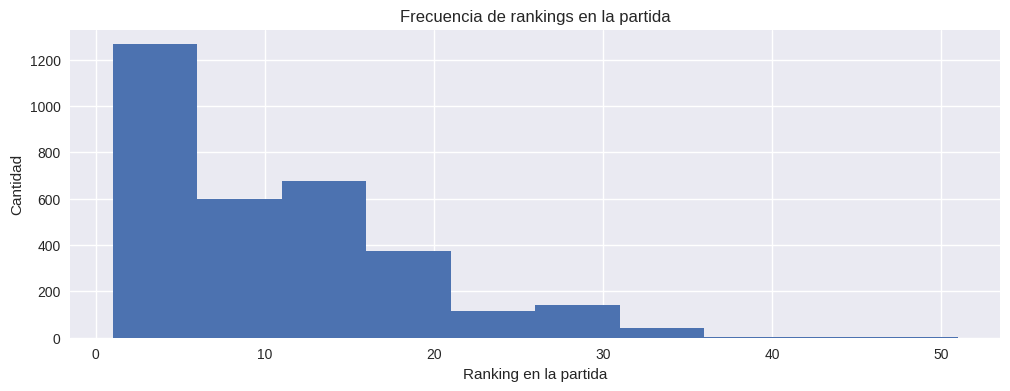

In [ ]:
mpl.style.use('seaborn-v0_8')

plt.figure(figsize=(12, 4))
plt.hist(data.winPlace)
plt.xlabel('Ranking en la partida')
plt.title('Frecuencia de rankings en la partida')
plt.ylabel('Cantidad')
plt.show()

Graficando la distribución de nuestra variable objetivo (ranking en la partida), se observa que la misma posee un sesgo hacia la derecha. Esto significa que los resultados para las partidas analizadas tienden a mostrar buenos rankings, lo cual es de esperarse ya que estamos analizando jugadores profesionales.

### ***Profiling***

Se aplica pandas profiling para analizar todas las variables que componen el df, así como las relaciones entre ellas.

In [ ]:
#Data Profiling
profile = ydata_profiling.ProfileReport(data)
profile

Output hidden; open in https://colab.research.google.com to view.

Analizando nuestra variable objetivo ```'winPlace'```, el profiling nos informa que esta posee una alta correlación con las variables ```'damageDealt'```, ```'kills'```, ```'longestKill'```, ```'timeSurvived'``` (negativa con todas estas) y ```'killPlace'``` (positiva).

Nota: Recordar para el análisis que la escala de la variable objetivo es descendente; es decir 1 es la mejor posición obtenible y 100 la peor.

### ***Preguntas puntuales***

A partir de la información obtenida pueden responderse algunas preguntas como:
* Cual es el nivel de precisión de los jugadores de nivel competitivo en cuanto a puntería?
* Cual es el tipo de muerte mas predominante?
* Qué tanto influye el uso de vehículos para mejorar la supervivencia?
* Hay algún día de la semana donde se jueguen mas partidas? Mejora la performance en dichos días?

y a partir de estas:
* Cuales son las features que mayor influencia tienen en el resultado de una partida?

#### Cual es el nivel de precisión de los jugadores de nivel competitivo en cuanto a puntería?

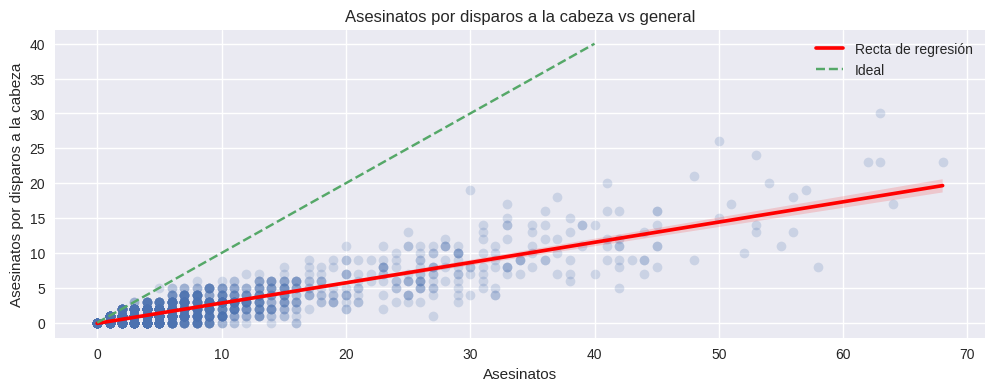

In [ ]:
plt.figure(figsize=(12, 4))
sns.regplot(data=data, x='kills', y='headshotKills',
            scatter_kws={'alpha':.2},
            line_kws={"color": "red"})
plt.plot([0, 40], [0, 40], ls="dashed")
plt.legend(['_','Recta de regresión', '_', 'Ideal'])
plt.xlabel('Asesinatos')
plt.ylabel('Asesinatos por disparos a la cabeza')
plt.title('Asesinatos por disparos a la cabeza vs general')

warnings.filterwarnings("ignore", category=UserWarning)

plt.show()

Nota: la cabeza es el lugar del cuerpo donde más daño produce un disparo, seguido por el torso y por último las extremidades. Por esta razón es que resulta conveniente intentar dar en esa zona del cuerpo del enemigo siempre que sea posible (por una cuestión de superficie resulta más sencillo dar en el torso). Un disparo con un rifle de alto calibre a la cabeza matará instantáneamente al enemigo excepto que este posea un casco.


En este gráfico se observa la alta correlación que existe entre asesinatos por disparos a la cabeza vs los generales. Pero probablemente lo más interesante sea comparar dicha recta de regresión con el ideal (todos los asesinatos son realizados por disparos a la cabeza). Mientras más se aparte una recta de otra, peor es la puntería del jugador o a lo sumo más ineficiente. Habría que comparar este gráfico con uno realizado para jugadores a nivel no competitivo (el archivo '.csv' de entregas anteriores por ejemplo); **pero en principio el hecho de matar por disparos a la cabeza no parece ser un factor determinante.**

#### Cual es el tipo de muerte mas predominante?

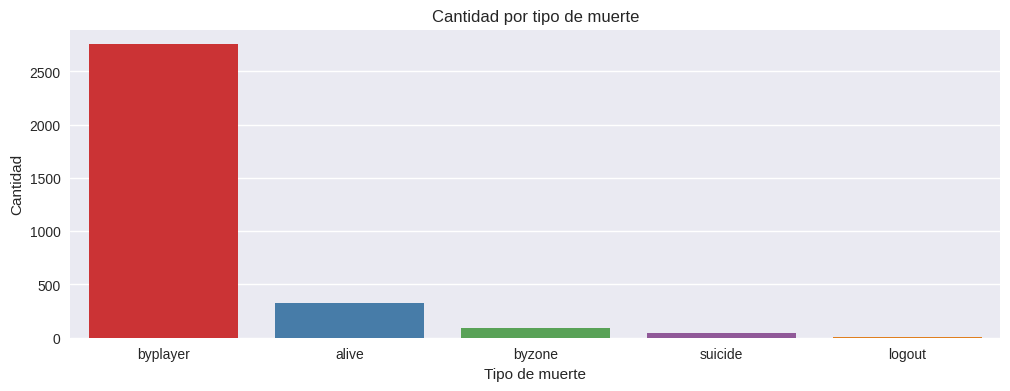

In [ ]:
plt.figure(figsize=(12, 4))
sns.countplot(data=data, x='deathType', order=data.deathType.value_counts().index, palette="Set1")
plt.xlabel('Tipo de muerte')
plt.ylabel('Cantidad')
plt.title('Cantidad por tipo de muerte')
plt.show()

Se observa que la mayor parte de los jugadores mueren asesinados por otro jugador, luego le sigue un grupo pequeño que se encuentran vivos al finalizar (son los ganadores de la partida), y por último un grupo mínimo de jugadores que mueren ya sea por la zona (cierre del mapa con el paso del tiempo), por suicidio o desconexión.

#### Es importante el uso de vehículos para mejorar la supervivencia?

In [ ]:
data['top10'] = data['winPlace'] <= 10

Se genera una variable booleana según si el jugador se encuentra en el top 10 de la partida o no.

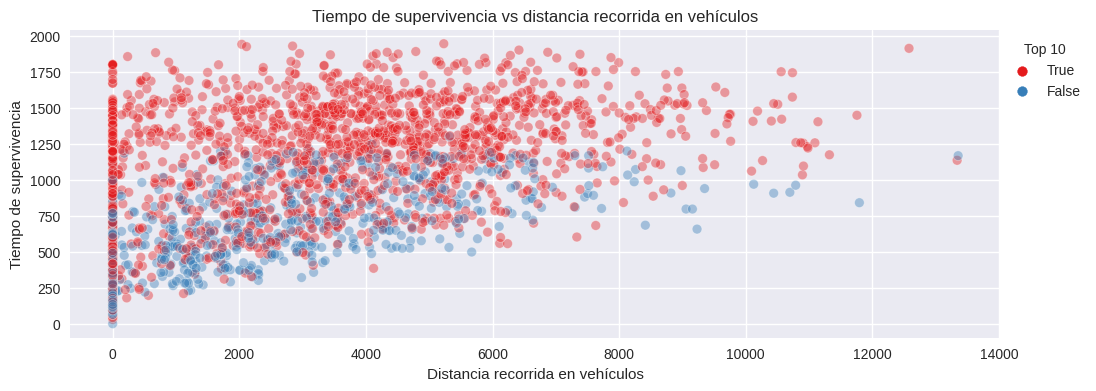

In [ ]:
plt.figure(figsize=(12, 4))
_ = sns.scatterplot(data=data, x='rideDistance', y='timeSurvived', alpha=.4, hue='top10', hue_order = [True, False], palette="Set1")
plt.legend(title='Top 10', bbox_to_anchor=(1.1, 1))
plt.xlabel('Distancia recorrida en vehículos')
plt.ylabel('Tiempo de supervivencia')
plt.title('Tiempo de supervivencia vs distancia recorrida en vehículos')
plt.show()

En este caso, se ha graficado el tiempo de supervivencia vs la distancia recorrida en vehículo, y se han coloreado los puntos según si pertenecen al top 10 de ranking o no.

Si se analiza el tiempo de supervivencia con el coloreado, se observan que los puntos pertenecientes al top 10 se posicionan por encima de los otros, indicando lógicamente que un mayor tiempo de supervivencia conlleva a mejores rankings. Si ahora realizamos el mismo análisis con la distancia recorrida en vehículos, la distribución se observa similar para ambos grupos.

Analizando ahora la nube de puntos en su totalidad, pueden observarse 2 grupos; el primero posee una distancia recorrida de 0 (jugadores que no utilizaron vehículos) y sus tiempos de supervivencia se encuentran distribuidos desde valores mínimos hasta máximos de la serie. El segundo grupo se conforma por jugadores que si utilizaron vehículos, en este caso se observa que a mayor distancia recorrida en ellos, mayor tiende a ser el tiempo de supervivencia.

**Por lo cual podría decirse que si necesito recorrer distancias mayores, es recomendable el uso de vehículos para hacerlo (la necesidad dependerá según como vaya cerrando el mapa con el paso del tiempo).**

#### Hay algún día de la semana donde se jueguen mas partidas? Mejora la performance en dichos días?

In [ ]:
data['weekday'] = data['dates'].dt.weekday
# Se crea una variable con número de día
weekday_dict = {0 : 'Monday',
                1 : 'Tuesday',
                2 : 'Wednesday',
                3 : 'Thursday',
                4 : 'Friday',
                5 : 'Saturday',
                6 : 'Sunday'}
data['weekday_name'] = data['weekday'].map(weekday_dict)
# A partir del número de día, se crea una nueva variable con su nombre correspondiente
data.head()

,dates,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,...,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,weekday,weekday_name
0,2023-08-07 21:09:19+00:00,0,0,0,4752.33500,byplayer,16,0,1,3,...,0,0.0,0,1200,0,0.00000,1,1,0,Monday
1,2023-08-07 20:08:11+00:00,9,3,9,2179.90230,byplayer,2,1,1,3,...,0,0.0,0,1420,1,1602.02510,7,3,0,Monday
2,2023-08-07 19:55:17+00:00,1,4,1,278.54318,byplayer,0,3,10,1,...,0,0.0,0,539,0,866.34393,4,13,0,Monday
3,2023-08-07 19:36:06+00:00,3,1,2,313.16425,byplayer,1,2,5,2,...,0,0.0,0,736,0,748.86190,4,8,0,Monday
4,2023-08-07 19:23:59+00:00,1,0,2,156.78546,byplayer,0,1,18,1,...,0,0.0,0,410,0,467.64468,6,13,0,Monday


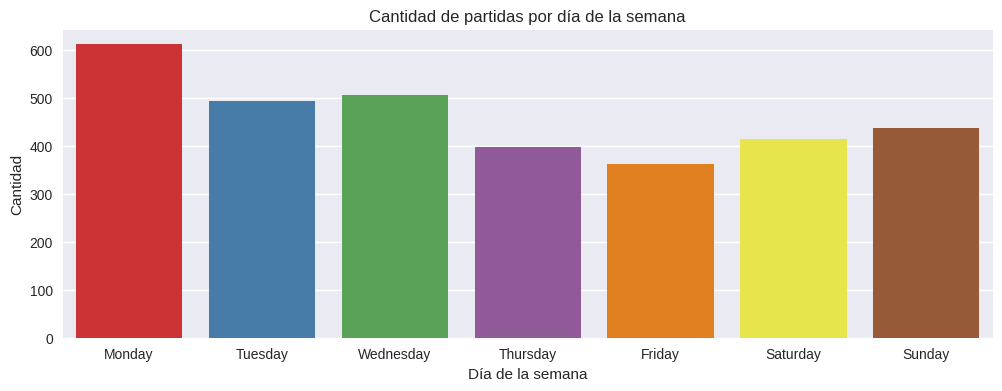

In [ ]:
plt.figure(figsize=(12, 4))
sns.countplot(data=data, x='weekday_name', order=weekday_dict.values(), palette="Set1")
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad')
plt.title('Cantidad de partidas por día de la semana')
plt.show()

**Se observa un pico de cantidad de partidas disputadas los Lunes, y luego el valor se mantiene alrededor de una media algo superior a  las 400 para el resto de la semana, presentando un mínimo los Viernes.**

In [ ]:
win_day = data.groupby('weekday_name')[['winPlace']].mean().reindex(weekday_dict.values())
win_day

,winPlace
weekday_name,
Monday,10.416667
Tuesday,9.232794
Wednesday,10.221344
Thursday,9.586902
Friday,7.806630
Saturday,9.527711
Sunday,10.105023


Se realiza un agrupamiento por día de la semana y se calcula el ranking medio para cada día.

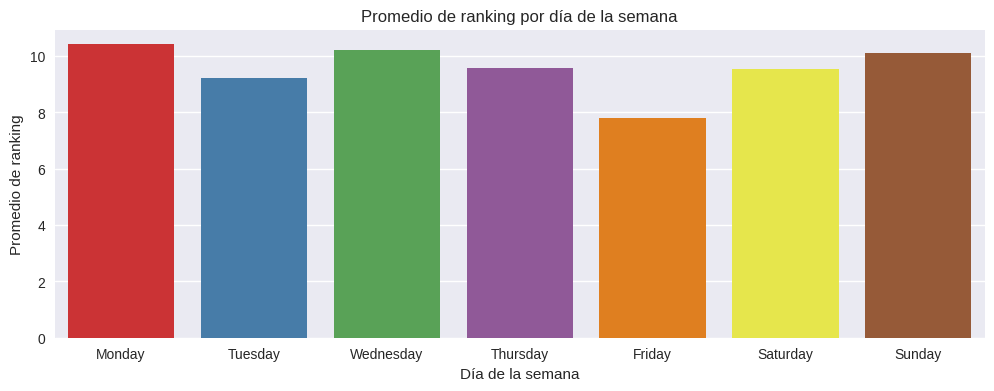

In [ ]:
plt.figure(figsize=(12, 4))
sns.barplot(data=win_day, x=win_day.index, y='winPlace', palette="Set1")
plt.xlabel('Día de la semana')
plt.ylabel('Promedio de ranking')
plt.title('Promedio de ranking por día de la semana')
plt.show()

Nota: recordar que a menor nro de ranking, mejor es la posición obtenida.

**Los días Viernes (día en que se disputan menos partidas), los rankings tienden a ser mejores.**

### ***Variables sintéticas y preparación de features***

Es una buena práctica generar nuevas features a partir de las propias que ya posee el df.

In [ ]:
data['KA'] = data['kills'] + data['assists']
# Un indicador en gran cantidad de juegos es el KDA ((kills + assists) / deaths). Siendo que en este caso la partida termina para el jugador con su muerte,
# se tomará sólo la primer parte de la fórmula.

data['dmg/kill'] = data['damageDealt'] / data['kills']
# Daño inflingido por cada asesinato.

data['consumables'] = data['boosts'] + data['heals']
# Consumibles utilizados durante la partida.

In [ ]:
data['dmg/kill'].describe()
# Para esta variable creada, se observan algunos datos con valor ∞ (aquellos que inflingieron daño pero no mataron a otro jugador) y otros nan
# (aquellos que no inflingieron daño ni mataron a otro jugador). Ambas son indeterminaciones matemáticas que debemos subsanar.

count    2997.000000
mean             inf
std              NaN
min        10.185165
25%       111.854810
50%       152.000000
75%       319.776980
max              inf
Name: dmg/kill, dtype: float64

In [ ]:
data['dmg/kill'].value_counts().sort_index()

10.185165        1
18.572147        1
19.373673        1
24.485317        1
24.756695        1
              ... 
724.145750       1
727.095900       1
856.755500       1
1155.669400      1
inf            617
Name: dmg/kill, Length: 2319, dtype: int64

In [ ]:
data['dmg/kill'].replace([np.inf, np.nan], 0, inplace=True)
# Podemos remplazar los valores tanto nulos como ∞ por valores 0, lo cual si bien no es matemáticamente correcto, al no tener valores originales en 0
# no debería introducir mayores errores al modelo.

In [ ]:
data['dmg/kill'].describe()

count    3224.000000
mean      117.617414
std       104.905776
min         0.000000
25%         0.000000
50%       112.705961
75%       158.492967
max      1155.669400
Name: dmg/kill, dtype: float64

In [ ]:
A = data.drop(labels=['winPlace', 'dates', 'name', 'playerId', 'deathType', 'weekday_name', 'top10'], axis=1)
B = pd.get_dummies(data[['deathType']])
X = pd.concat([A,B],axis=1)

X.shape

(3224, 28)

Se crea nuestro conjunto de features, dummeando la única variable categórica que tenemos, ```'deathType'```. Las variables ```'dates'```, ```'name'``` y ```'playerId'``` se eliminan por ser fechas y metadatos respectivamente. ```'weekday_name'``` puede eliminarse porque ya contamos con el día en formato numérico en ```'weekday'```. Por último, ```'top10'``` se elimina ya que fue creada a partir de la variable objetivo a modo de indicador para algunos gráficos; y por supuesto ```'winPlace'``` se quita por ser dicha variable objetivo.


In [ ]:
y = data["winPlace"]

y.shape

(3224,)

Creamos la variable objetivo.

In [ ]:
columns = X.columns

scaler = MinMaxScaler()

X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = columns)
# Se escalan los features

#### Cuales son las features que mayor influencia tienen en el resultado de una partida?

In [ ]:
def forward_selection(data, target, significance_level=0.01):

    """Función que prueba todas las distintas combinaciones de variables, evaluandolas con sus p_value"""

    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features,dtype="float64")
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [ ]:
feats = forward_selection(X,y)
feats
# La función nos selecciona las features que minimizan el error en el modelo de regresión aplicado mediante un forward selection.

['killPlace',
 'timeSurvived',
 'KA',
 'DBNOs',
 'dmg/kill',
 'deathType_alive',
 'killStreaks',
 'weaponsAcquired',
 'assists',
 'kills',
 'damageDealt']

Como conclusiones, podemos agrupar las variables obtenidas por:

* *Enfrentamientos con otros jugadores*: ```'killPlace'```, ```'KA'```, ```'DBNOs'```, ```'dmg/kill'```, ```'killStreaks'```, ```'assists'```, ```'kills'```, ```'damageDealt'```. Todas haciendo referencia a las muertes, daño y asistencias producidas.

* *Supervivencia*: ```'timeSurvived'```, ```'deathType_alive'```, ```'weaponsAcquired'```. Todas haciendo referencia al equipamiento y la capacidad de seguir en partida.

### ***Entrenamiento y selección de modelos***

In [ ]:
X = X[feats].drop(labels=['dmg/kill'], axis=1)

Utilizaremos las features más significativas halladas por el método anterior como variables de entrada para el entrenamiento de diversos modelos de regresión. Luego de haber realizado varias pruebas, se encontró que el rendimiento general es levemente superior quitando la variable ```'dmg/kill'```; de todas maneras la información provista por esta se le está dando a los modelos ya que dicha variable se formó a partir de ```'damageDealt'``` y ```'kills'```.

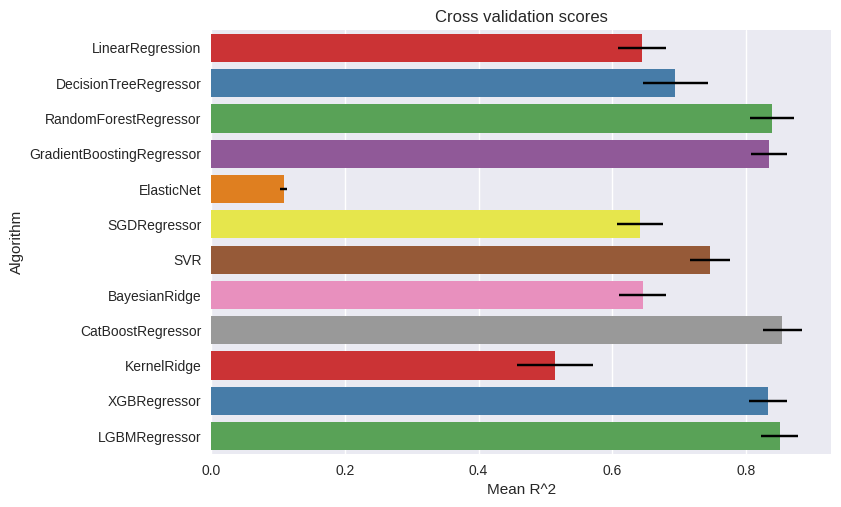

In [ ]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
models = []

models.append(LinearRegression())
models.append(DecisionTreeRegressor(random_state=42))
models.append(RandomForestRegressor(random_state=42))
models.append(GradientBoostingRegressor(random_state=42))
models.append(ElasticNet(random_state=42))
models.append(SGDRegressor(random_state=42))
models.append(SVR())
models.append(BayesianRidge())
models.append(CatBoostRegressor(random_state=42))
models.append(KernelRidge())
models.append(XGBRegressor(random_state=42))
models.append(LGBMRegressor(random_state=42))

cv_results = []
for model in models:
    cv_results.append(cross_val_score(model, X, y, scoring = "r2", cv = kf, n_jobs=-1))
    # Se aplican todos los modelos con parámetros por default, se utiliza validación cruzada k-folds y se calcula el r2 promedio y desviación estándar para cada modelo

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors":cv_std, "Algorithm":["LinearRegression", "DecisionTreeRegressor", "RandomForestRegressor",
"GradientBoostingRegressor", "ElasticNet", "SGDRegressor", "SVR", "BayesianRidge", "CatBoostRegressor", "KernelRidge", "XGBRegressor", "LGBMRegressor"]})

g = sns.barplot(data = cv_res, x="CrossValMeans", y="Algorithm", palette="Set1", orient = "h", **{'xerr':cv_std})
g.set_xlabel("Mean R^2")
g = g.set_title("Cross validation scores")

Del gráfico anterior, se destacan la mala performance de ```KernelRidge``` y aun peor de ```ElasticNet```. Ambos trabajan mediante una regresión lineal, la cual ya de por si para este caso no parte de una buena performance; el primero impone una penalización al tamaño de los coeficientes, lo cual evidentemente empeora su resultado. El segundo además de esto, realiza un feature selection de nuestras variables ya seleccionadas probablemente ocasionando así una pérdida de información.

Se seleccionarán entonces los 5 mejores modelos (cuya R^2 media ronda los 0.8) para su optimización de hiperparámetros; siendo estos ```RandomForestRegressor```, ```GradientBoostingRegressor```, ```CatBoostRegressor```, ```XGBRegressor``` y ```LGBMRegressor```.

### ***Hypertuning***

El proceso de hypertuneo consiste en configurar una red de parámetros para los modelos (con varios valores posibles para cada uno de ellos), evaluando la respuesta del modelo para cada combinación de los mismos mediante una validación cruzada de búsqueda aleatoria por mitades. Se devuelve luego la mejor combinación hallada, junto a su score más alto correspondiente. Este proceso se repite para los 5 modelos preseleccionados.

#### RandomForestRegressor

In [ ]:
rf = RandomForestRegressor()

rf_param_grid = {"n_estimators" : [100, 200, 300],
                 "criterion": ["squared_error"],
                 "max_depth": [3, 5, 8],
                 "min_samples_split": [2, 3, 6],
                 "min_samples_leaf": [1, 3, 6],
                 "max_features": [2, 5, 7],
                 }

rsrf = HalvingRandomSearchCV(rf, param_distributions = rf_param_grid, cv = kf, scoring="r2", n_jobs= -1, verbose = 1)

rsrf.fit(X, y)

rf_best = rsrf.best_estimator_

print('\nR^2 para RandomForestRegressor: ', rsrf.best_score_.round(4))
# Best score
print('\nParámetros óptimos para RandomForestRegressor:\n', rsrf.best_params_)
# Best params

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20
max_resources_: 3224
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 161
n_resources: 20
Fitting 10 folds for each of 161 candidates, totalling 1610 fits
----------
iter: 1
n_candidates: 54
n_resources: 60
Fitting 10 folds for each of 54 candidates, totalling 540 fits
----------
iter: 2
n_candidates: 18
n_resources: 180
Fitting 10 folds for each of 18 candidates, totalling 180 fits
----------
iter: 3
n_candidates: 6
n_resources: 540
Fitting 10 folds for each of 6 candidates, totalling 60 fits
----------
iter: 4
n_candidates: 2
n_resources: 1620
Fitting 10 folds for each of 2 candidates, totalling 20 fits

R^2 para RandomForestRegressor:  0.8265

Parámetros óptimos para RandomForestRegressor:
 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 7, 'max_depth': 8, 'criterion': 'squared_error'}


#### GradientBoostingRegressor

In [ ]:
gbr = GradientBoostingRegressor()

gbr_param_grid = {'loss' : ["squared_error"],
                  'learning_rate': [0.1, 0.05, 0.01],
                  'n_estimators' : [100, 200, 300],
                  'min_samples_leaf': [1, 3, 6],
                  'max_depth': [3, 5, 8],
                  'max_features': ['sqrt']
                  }

gsgbr = HalvingRandomSearchCV(gbr, param_distributions = gbr_param_grid, cv = kf, scoring="r2", n_jobs= -1, verbose = 1)

gsgbr.fit(X, y)

gbr_best = gsgbr.best_estimator_

print('\nR^2 para GradientBoostingRegressor: ', gsgbr.best_score_.round(4))
# Best score
print('\nParámetros óptimos para GradientBoostingRegressor:\n', gsgbr.best_params_)
# Best params

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20
max_resources_: 3224
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 20
Fitting 10 folds for each of 81 candidates, totalling 810 fits
----------
iter: 1
n_candidates: 27
n_resources: 60
Fitting 10 folds for each of 27 candidates, totalling 270 fits
----------
iter: 2
n_candidates: 9
n_resources: 180
Fitting 10 folds for each of 9 candidates, totalling 90 fits
----------
iter: 3
n_candidates: 3
n_resources: 540
Fitting 10 folds for each of 3 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 1
n_resources: 1620
Fitting 10 folds for each of 1 candidates, totalling 10 fits

R^2 para GradientBoostingRegressor:  0.8387

Parámetros óptimos para GradientBoostingRegressor:
 {'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'loss': 'squared_error', 'learning_rate': 0.1}


#### CatBoostRegressor

In [ ]:
cbr = CatBoostRegressor()

cbr_param_grid = {'iterations': [100, 150, 200],
                  'learning_rate': [0.1, .08, 0.05],
                  'depth': [3, 5, 8],
                  'l2_leaf_reg': [.1, 0.2, 0.5, 1]
                  }

gscbr = HalvingRandomSearchCV(cbr, param_distributions = cbr_param_grid, cv = kf, scoring="r2", n_jobs= -1, verbose = 1)

gscbr.fit(X, y)

cbr_best = gscbr.best_estimator_

print('\nR^2 para CatBoostRegressor: ', gscbr.best_score_.round(4))
# Best score
print('\nParámetros óptimos para CatBoostRegressor:\n', gscbr.best_params_)
# Best params

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20
max_resources_: 3224
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 20
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
----------
iter: 1
n_candidates: 36
n_resources: 60
Fitting 10 folds for each of 36 candidates, totalling 360 fits
----------
iter: 2
n_candidates: 12
n_resources: 180
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 4
n_resources: 540
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 2
n_resources: 1620
Fitting 10 folds for each of 2 candidates, totalling 20 fits
0:	learn: 7.5971294	total: 621us	remaining: 124ms
1:	learn: 7.2754390	total: 2.62ms	remaining: 259ms
2:	learn: 6.9810646	total: 3.75ms	remaining: 246ms
3:	learn: 6.7105401	total: 4.48ms	remaining: 220ms
4:	learn: 6.4113489	total: 5.02ms	remaining: 196ms
5:	learn: 6.1822911	tota

#### XGBRegressor

In [ ]:
xgb = XGBRegressor()

xgb_param_grid = {'n_estimators' : [50, 100, 200],
                  'max_depth' : [2, 3, 6],
                  'eta' : [0.1, 0.05, 0.01],
                  'subsample' : [.5, .4, .3],
                  'colsample_bytree' : [.7, .6, .5]
                  }

gsxgb = HalvingRandomSearchCV(xgb, param_distributions = xgb_param_grid, cv = kf, scoring="r2", n_jobs= -1, verbose = 1)

gsxgb.fit(X, y)

xgb_best = gsxgb.best_estimator_

print('\nR^2 para XGBRegressor: ', gsxgb.best_score_.round(4))
# Best score
print('\nParámetros óptimos para XGBRegressor:\n', gsxgb.best_params_)
# Best params

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20
max_resources_: 3224
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 161
n_resources: 20
Fitting 10 folds for each of 161 candidates, totalling 1610 fits
----------
iter: 1
n_candidates: 54
n_resources: 60
Fitting 10 folds for each of 54 candidates, totalling 540 fits
----------
iter: 2
n_candidates: 18
n_resources: 180
Fitting 10 folds for each of 18 candidates, totalling 180 fits
----------
iter: 3
n_candidates: 6
n_resources: 540
Fitting 10 folds for each of 6 candidates, totalling 60 fits
----------
iter: 4
n_candidates: 2
n_resources: 1620
Fitting 10 folds for each of 2 candidates, totalling 20 fits

R^2 para XGBRegressor:  0.8329

Parámetros óptimos para XGBRegressor:
 {'subsample': 0.3, 'n_estimators': 200, 'max_depth': 3, 'eta': 0.05, 'colsample_bytree': 0.6}


#### LGBMRegressor

In [ ]:
lgbm = LGBMRegressor()

lgbm_param_grid = {'num_leaves': [10, 20, 30, 40],
                   'learning_rate': [0.1, 0.05, 0.01],
                   'max_depth': [3, 5, 8],
                   'n_estimators': [100, 200, 300]
                  }

gslgbm = HalvingRandomSearchCV(lgbm, param_distributions = lgbm_param_grid, cv = kf, scoring="r2", n_jobs= -1, verbose = 1)

gslgbm.fit(X, y)

lgbm_best = gslgbm.best_estimator_

print('\nR^2 para LGBMRegressor: ', gslgbm.best_score_.round(4))
# Best score
print('\nParámetros óptimos para LGBMRegressor:\n', gslgbm.best_params_)
# Best params

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20
max_resources_: 3224
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 20
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
----------
iter: 1
n_candidates: 36
n_resources: 60
Fitting 10 folds for each of 36 candidates, totalling 360 fits
----------
iter: 2
n_candidates: 12
n_resources: 180
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 4
n_resources: 540
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 2
n_resources: 1620
Fitting 10 folds for each of 2 candidates, totalling 20 fits

R^2 para LGBMRegressor:  0.8522

Parámetros óptimos para LGBMRegressor:
 {'num_leaves': 40, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}


### ***Conclusiones***

De los modelos preseleccionados, se elige el LGBMRegressor que tiene la mejor respuesta, con un R^2 de 0.8522. Como posible mejora si se quisiera incrementar este indicador, se podria aplicar un feature_importances_ para los 5 modelos, de manera de determinar a que features cada modelo le asigna mayor peso. Luego, asegurándonos de seleccionar modelos que ponderen más a las distintas features, se podrian combinar varios de ellos mediante el método de bagging; siendo la respuesta global del nuevo modelo ensamblado mejor a la de cada uno de ellos por separado, logrando reducir así la varianza en las estimaciones.

A la vez, se han logrado identificar las features que mayor influencia tienen en la variable objetivo, siendo estas agrupables en 2 grupos:

* *Enfrentamientos con otros jugadores*: ```'killPlace'```, ```'KA'```, ```'DBNOs'```, ```'dmg/kill'```, ```'killStreaks'```, ```'assists'```, ```'kills'```, ```'damageDealt'```.

* *Supervivencia*: ```'timeSurvived'```, ```'deathType_alive'```, ```'weaponsAcquired'```.